In [7]:
import juliacall
from juliacall import Main as jl
import pandas as pd
import json
import numpy as np
import os
import os.path as osp
from copy import copy
import regex as re
from pathlib import Path
import sys
sys.path.append("..")
from outlier_analysis.gather_scores import gather_scores, free_gather_scores, gather_scores_in_df
import matplotlib.pyplot as plt

In [2]:
juliacall.using(locals(), "CairoMakie")
juliacall.using(locals(), "CairoMakie", 'lines! scatter! hidespines! linkaxes!', rename=lambda x: x.replace("!", "___"))
juliacall.using(locals(), "CairoMakie", 'hidedecorations! hidexdecorations! hideydecorations! xticks!', rename=lambda x: x.replace("!", "___"))
juliacall.using(locals(), "Distributions")
juliacall.using(locals(), "CairoMakie", 'plot! scatter!', rename=lambda x: x.replace("!", "__"))
juliacall.using(locals(), 'Colors')
juliacall.using(locals(), 'ColorSchemes')

In [3]:
def turn2row(df, newindex, idxs=[[]]):
    newidxs = ["full_model", "out_1", "out_2", "out_1&2"]
    converter = {
        i:j for i,j in enumerate(newidxs)
    }
    byrow = df.T
    byrow.reset_index(inplace=True)
    byrow.rename({str(idx)[1:-1]:converter[n] for n,idx in enumerate(idxs)}, axis=1, inplace=True)
    byrow["newindex"] = [newindex] * df.T.shape[0]
    byrow.set_index(["newindex", "index"], inplace=True)
    return byrow.loc[:, newidxs]

In [4]:
scores_full_list = [os.path.join("../baselines/output/scores/", i) for i in os.listdir("../baselines/output/scores") if "multiberts" in i and "_1_" in i]
scores_full_list = [i for i in scores_full_list if len(os.listdir(i)) > 0]
scores_full_list = [
    (
        gather_scores_in_df(i, include=["mnli"], include_or=["218", "674", "[]"], exclude=["205", "461", "61", "15"]).rename({"218, 674": "674, 218"}),  
        "seed_1_" + re.search("step_\d+", i).group(0), 
        [[], [674], [218], [674, 218]]
    )
    for i in scores_full_list if "_1_" in i
]
out_df = []
for i in scores_full_list:
    try:
        out_df.append(turn2row(*i))
    except:
        pass
multiberts_1_full_df = (
    pd.concat(
    out_df
    ).round(3) * 100
)
multiberts_newindex = sorted(multiberts_1_full_df.index, key=lambda x:int(re.search("step_(\d+)", x[0]).group(1)))
multiberts_1_full_df = multiberts_1_full_df.loc[multiberts_newindex, :]

In [5]:
multiberts_df_1_toplot = multiberts_1_full_df.set_index(multiberts_1_full_df.index.map(lambda x:(re.search("\d+$", x[0]).group(0), x[1])))
multiberts_df_1_toplot.index.names = ["n_steps", "index"]
multiberts_df_1_toplot = multiberts_df_1_toplot.rename(
    {'out_1':"First Outlier", 'out_2':"Second Outlier", 'out_1&2':"Both Outliers", 'full_model':"Full Model"},
    axis=1
)
df1 = multiberts_df_1_toplot.groupby('index').get_group('mnli').reset_index('index').drop('index', axis=1)
df2=multiberts_df_1_toplot.groupby('index').get_group('mnli-mm').reset_index('index').drop('index', axis=1)


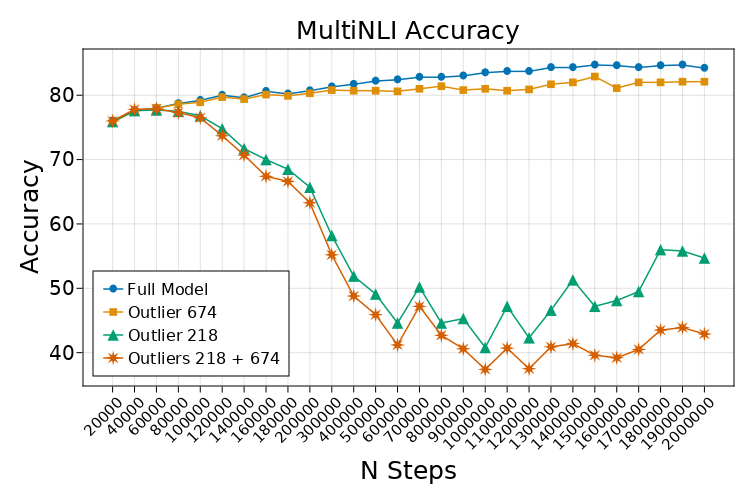

In [12]:
colors = jlColorSchemes.seaborn_colorblind
# colors = [colors[i] for i in range(1, 11, 2)]
fig1 = jlCairoMakie.Figure(resolution=(750, 500))
fig2 = jlCairoMakie.Figure(resolution=(750, 500))
ga = fig1[1,1] = jlCairoMakie.GridLayout()
gb = fig2[1,1] = jlCairoMakie.GridLayout()
ax1 = jlCairoMakie.Axis(ga[1,1])
ax2 = jlCairoMakie.Axis(gb[1,1])
labels = ["Full Model", "Outlier 674", "Outlier 218", "Outliers 218 + 674"]
markers = [jl.Symbol("circle"), jl.Symbol("rect"), jl.Symbol("utriangle"), jl.Symbol("star8")]
marker_sizes = [10, 10, 15, 20]
for i in range(4):
    lines___(ax1, df1.iloc[:, i].to_numpy(), color=colors[i+1], label=labels[i])
    scatter___(ax1, df1.iloc[:, i].to_numpy(), markersize=marker_sizes[i], marker=markers[i], color=colors[i+1], label=labels[i])

    lines___(ax2, df2.iloc[:, i].to_numpy(), color=colors[i+1], label=labels[i])
    scatter___(ax2, df2.iloc[:, i].to_numpy(), markersize=marker_sizes[i], marker=markers[i], color=colors[i+1], label=labels[i])

linkaxes___(ax1, ax2)
hideydecorations___(ax2, label = True, ticklabels = True, ticks = False, grid = False,
    minorgrid = False, minorticks = False)
for ax in [ax1, ax2]:
    ax.xticks = np.array(range(1, df1.shape[0]+1)), np.array([i for i in df1.index])
    ax.xticklabelrotation = jl.pi / 4
    ax.xticklabelsize = 15
    ax.xlabel = "N Steps"
    ax.xlabelsize = 25

ax1.ylabel = "Accuracy"
ax1.ylabelsize = 25
ax1.yticklabelsize = 20
ax1.title = "MultiNLI Accuracy"
ax1.titlesize = 25
ax2.title = "MultiNLI Mismatched Accuracy"
ax2.titlesize = 25
jlCairoMakie.axislegend(ax1, position=jl.Symbol("lb"), merge=True, unique=True)
jlCairoMakie.axislegend(ax2, position=jl.Symbol("lb"), merge=True, unique=True)
# for label, layout in zip(["a)", "b)"], [ga, gb]):
#     jlCairoMakie.Label(layout[1, 1, jlCairoMakie.TopLeft()], label,
#         textsize = 26,
#         # font = noto_sans_bold,
#         padding = (0, 5, 5, 0),
#         # halign = :right
#         )
outpath = Path("../overleaf/hacking_outlier_features/restiled_plots/multiberts_over_pretraining/")
outpath.mkdir(parents=True, exist_ok=True)
jlCairoMakie.save(str(outpath / "mnli_acc_plot_julia.png"), fig1)
jlCairoMakie.save(str(outpath / "mnli-mm_acc_plot_julia.png"), fig2)
fig1

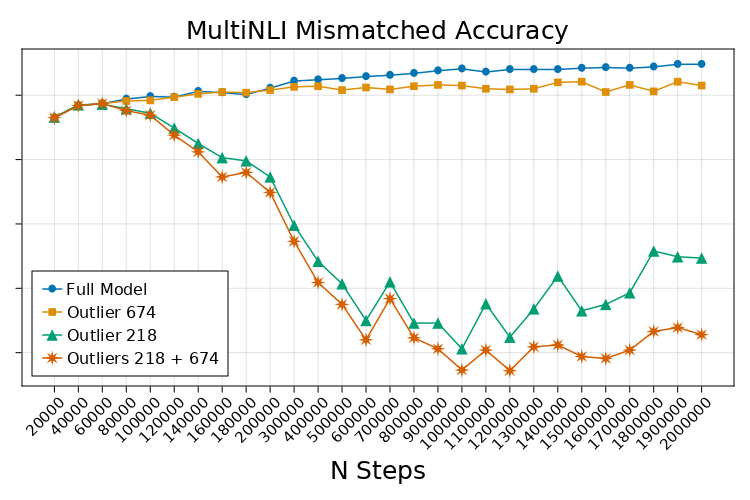

In [13]:
fig2